In [1]:
import numpy as np; import matplotlib.pyplot as plt 
import seaborn as sns;import pymc3 as pm 
import theano ;import pandas as pd
from theano import shared, tensor as tt

Couldn't import dot_parser, loading of dot files will not be possible.


In [91]:
import os
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("Tremblay_Data.csv", engine = "python")
temp= df['temp'].values
data = df['data'].values

In [92]:
X = temp + 273.15; qq = data
tplot = 10000/X; N = len(qq)
idx = np.linspace(0, N-1, N).astype(int)

In [93]:
x = X[:, np.newaxis]
data = qq[:, np.newaxis]
N = data.shape[0]
idx = np.linspace(0, N-1, N).astype(int)

# Non-Parametric 

In [94]:
def stick_break(beta): 
    zz = tt.concatenate(([[1], tt.extra_ops.cumprod(1- beta)[:-1]]))
    return beta*zz

In [95]:
import pymc3.distributions.transforms as tr
Q = pm.Model() 
k = 10
R = 8.314e-3
with Q: 
    
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape = k)
    w_ = stick_break(beta)
    w = pm.Deterministic('w', w_/w_.sum(axis = 0, keepdims = True))
    
    z = pm.Categorical('z', p = w, 
                      shape = N)

In [96]:
with Q: 

    # Diffusion Kinetics
    ea = pm.Normal('Ea', mu = 90, sd = 2)
    
    d0 = pm.HalfNormal('D0', sd = 50)
    
    # Grain effective Diffusive lengthscale 
    a = pm.HalfNormal('a', sd = 0.1, 
                   shape = k)
    #lnd0a2
    lnd0a2 = pm.Deterministic('Lnd0a2', 
                             np.log(d0/(a[z]**2)))
    
    # Model
    mu = pm.Deterministic('model', 
                          tt.log(w[z]**2*(d0/(a[z]**2)) \
                         * tt.exp(-ea/(R \
                                * X[idx]))))

# Normal Mixture Sum of Squares Likelihood

In [97]:
with Q: 
    sd = pm.HalfNormal('sd', sd = 0.15, shape = k)
    obs = pm.Normal('obs', mu, sd = sd[z],
                          observed = qq)
    

In [98]:
for RV in Q.basic_RVs: 
    print(Q.name, Q.logp(Q.test_point))

 -46729.12793423441
 -46729.12793423441
 -46729.12793423441
 -46729.12793423441
 -46729.12793423441
 -46729.12793423441
 -46729.12793423441
 -46729.12793423441


In [100]:
with Q: 
    step1 = pm.CategoricalGibbsMetropolis([z])
    step2 = pm.Metropolis([ea, d0, a, sd,
                           alpha, beta])
    trace = pm.sample(50000, tune = 75000, 
                     step = [step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [z]
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>>Metropolis: [sd]
>>Metropolis: [a]
>>Metropolis: [D0]
>>Metropolis: [Ea]
Sampling 2 chains: 100%|██████████| 250000/250000 [16:42<00:00, 249.42draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


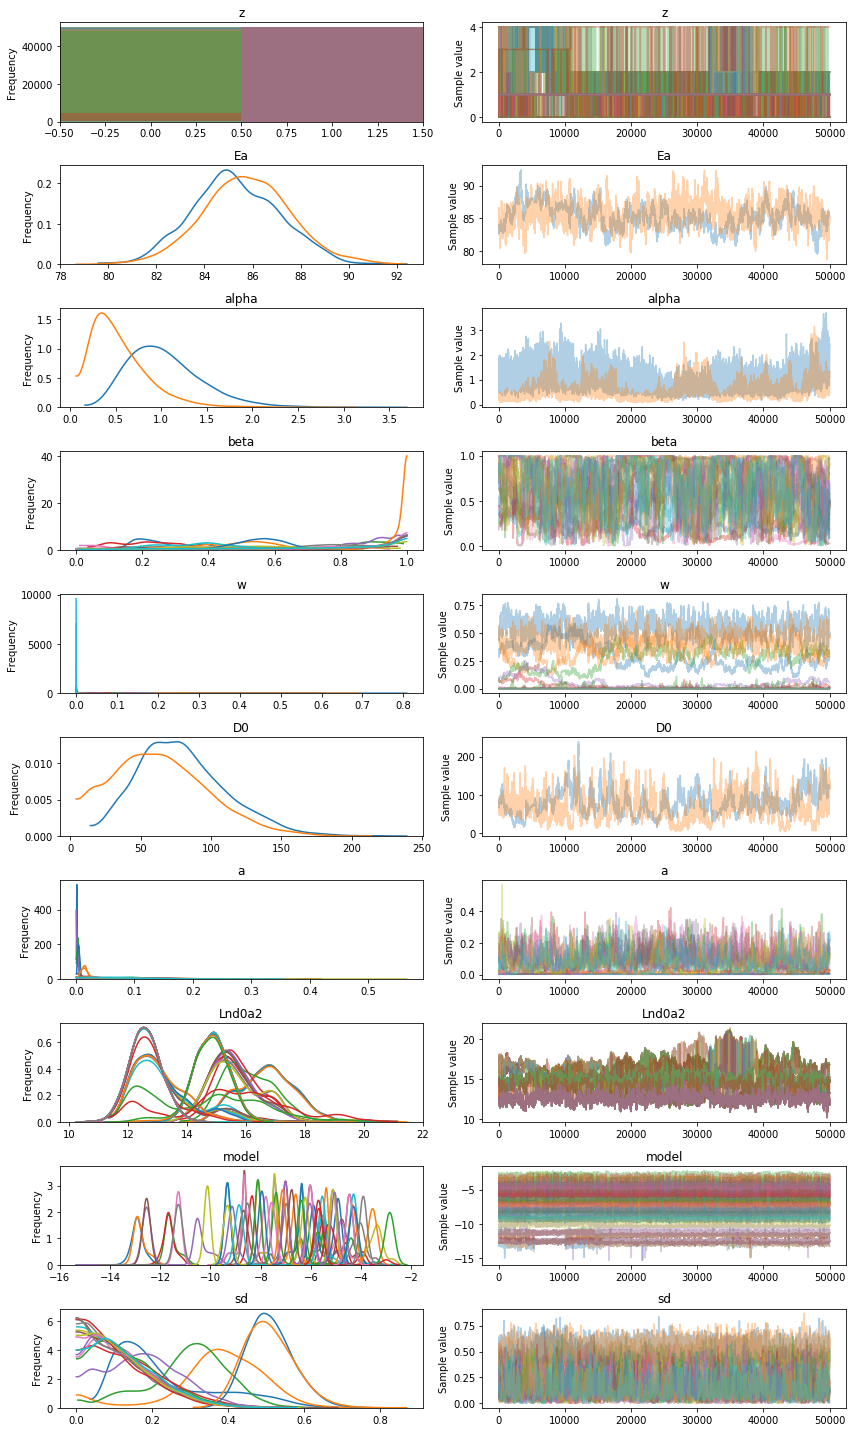

In [101]:
pm.traceplot(trace); 

In [102]:
with Q: 
    ppc = pm.sample_ppc(trace, 1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 1000/1000 [00:00<00:00, 1335.30it/s]


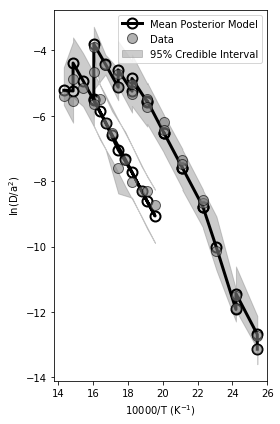

In [115]:
plt.figure(figsize = (4,6))
plt.plot(tplot,ppc['obs'].mean(axis = 0), '-o', 
        markeredgewidth =2 , markeredgecolor = 'k',
        markerfacecolor = 'None', color = 'k',
        ms = 10, lw = 3, 
        label = 'Mean Posterior Model');
#plt.plot(tplot, trace['model'].mean(axis = 0).mean(axis = 0), '-o', 
#        markeredgewidth =2 , markeredgecolor = 'r', 
#         markerfacecolor = 'None', 
#        ms = 10, lw = 3)
plt.plot(tplot,data, 'o', 
          color= 'grey', markeredgecolor = 'k', ms = 10, 
         alpha = 0.6, 
        label = 'Data') 
low, high = np.percentile(ppc['obs'], [2.5, 97.5], 
                         axis = 0)
plt.fill_between(tplot, low, high, color = 'grey', 
                alpha = 0.4, interpolate = True, 
                label = '95% Credible Interval')
plt.xlabel('10000/T (K$^{-1}$)')
plt.ylabel('ln(D/a$^{2}$)')
plt.tight_layout()
plt.legend()
plt.savefig('Tremblay_arrhenius.pdf')

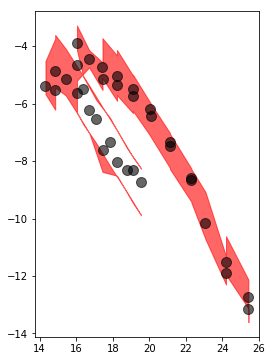

In [116]:
low, high = np.percentile(ppc['obs'], [2.5, 97.5], 
                         axis = 0)
plt.figure(figsize = (4,6))
plt.fill_between(tplot, low, high, color = 'r', 
                alpha = 0.6)
plt.plot(tplot,data, 'o', 
          color= 'k', markeredgecolor = 'k', ms = 10, 
         alpha = 0.6) 

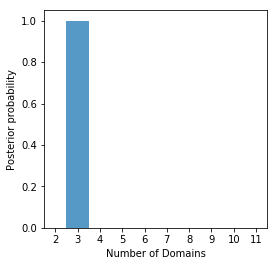

In [117]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size,
                                1, 
                                trace['z'][-5000:])
fig, ax = plt.subplots(figsize=(4, 4))

bins = np.arange(k)
ax.hist(n_domains + 1, bins=bins, normed=True,
        lw=3, alpha=0.75);


bins = np.arange(n_domains.min(),
                 n_domains.max() + 10)
ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of Domains');
#ax.set_ylim(0,0.0001)

ax.set_ylabel('Posterior probability');

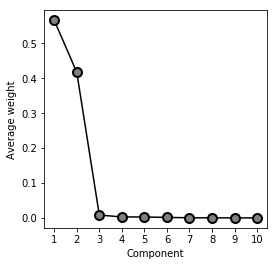

In [118]:
plt.figure(figsize = (4, 4))
plot_w = np.arange(k)
plt.plot(plot_w, trace['w'][-5000:].mean(0), '-o', 
        color = 'k', 
        markersize = 9, 
        markeredgecolor = 'k', 
        markerfacecolor = 'grey', 
        markeredgewidth = 2)
plt.xticks(plot_w, plot_w + 1);
plt.xlabel('Component'); 
plt.ylabel('Average weight'); 

# Combined No. 0f Domains and Domain Weight Plots

In [136]:
xx = trace['Ea'][-10000::3]
yy = trace['Lnd0a2'][-10000::3].mean(1)
yy

array([14.01274493, 14.02690644, 14.19840113, ..., 13.63872427,
       13.77866847, 13.69727262])

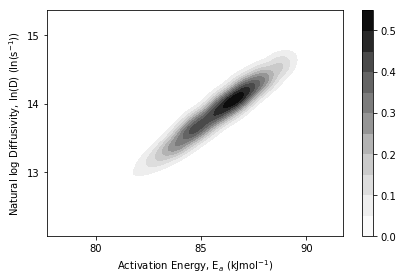

In [141]:
ax = sns.kdeplot(xx, yy, shade = True,shade_lowest=False,
                cmap = 'Greys', cbar = True)
ax.set_xlabel('Activation Energy, E$_{a}$ (kJmol$^{-1}$)')
ax.set_ylabel('Natural log Diffusivity, ln(D) (ln(s$^{-1}$))')

plt.locator_params(nbins=5)
plt.tight_layout()

plt.savefig('Tremblay_diffusionkinetics.pdf')

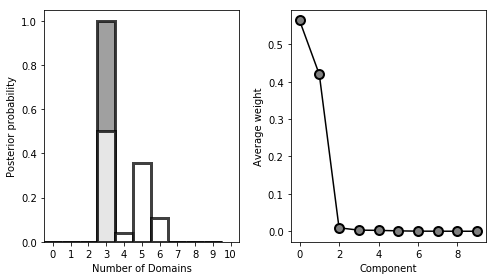

In [125]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size,
                                1, 
                                trace['z'][-5000:])


fig, ax = plt.subplots(1,2, figsize = (7,4))
ax[0].hist(n_domains + 1, bins=bins, normed=True,
        lw=3, alpha=0.75, 
       edgecolor = 'k', 
       facecolor = 'grey');


bins = np.arange(k + 1)
ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(), bins.max() + 1);
ax[0].set_xlabel('Number of Domains');
#ax.set_ylim(0,0.0001)

ax[0].set_ylabel('Posterior probability');


plot_w = np.arange(k)
ax[1].plot(plot_w, trace['w'][-10000:].mean(0), '-o', 
        color = 'k', 
        markersize = 9, 
        markeredgecolor = 'k', 
        markerfacecolor = 'grey', 
        markeredgewidth = 2)

#ax[1].set_xticks(plot_w, plot_w+ 1)

ax[1].set_xlabel('Component'); 
ax[1].set_ylabel('Average weight');
plt.tight_layout()
plt.savefig('ndomains_tremblay.pdf')

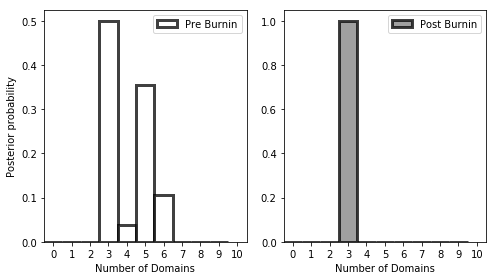

In [130]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size,
                                1, 
                                trace['z'][-5000:])

n_domains2 = np.apply_along_axis(lambda x: np.unique(x).size,
                                1, 
                                trace['z'])


fig, ax = plt.subplots(1,2, figsize = (7,4))
ax[1].hist(n_domains + 1, bins=bins, normed=True,
        lw=3, alpha=0.75, 
       edgecolor = 'k', 
       facecolor = 'grey', 
          label = 'Post Burnin');


bins = np.arange(k + 1)
ax[1].set_xticks(bins + 0.5);
ax[1].set_xticklabels(bins);
ax[1].set_xlim(bins.min(), bins.max() + 1);
ax[1].set_xlabel('Number of Domains');
#ax.set_ylim(0,0.0001)

ax[0].set_ylabel('Posterior probability');



ax[0].hist(n_domains2 + 1, bins=bins, normed=True,
        lw=3, alpha=0.75, 
       edgecolor = 'k', 
       facecolor = 'w', 
          label = 'Pre Burnin');


bins = np.arange(k + 1)
ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(), bins.max() + 1);
ax[0].set_xlabel('Number of Domains');
#ax.set_ylim(0,0.0001)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('pre_post_burn_tremblay.pdf')



# Ln(r/r0) plot

In [85]:
r1 = ppc['obs'].mean(axis = 0)
r0 = qq

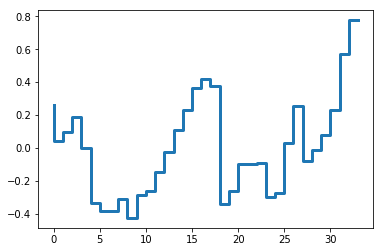

In [86]:
q = 0.5*(r1 - r0)

plt.plot(q, 
        '-', drawstyle = 'steps',
        markeredgecolor = 'k', 
        markeredgewidth = 1.3, 
        markersize  = 9, lw = 3); 

KeyError: 'Unknown variable phi'

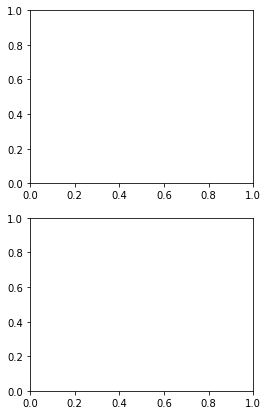

In [87]:
fig, ax = plt.subplots(2,1,figsize = (4,7))
ax[0].bar(np.arange(k) + 1, 
      trace['phi'].mean(axis = 0).max(axis = 0), 
      label = 'No Burn', alpha = 0.6, lw = 2, 
         color = 'grey'); 

ax[1].bar(np.arange(k) + 1, 
      trace['phi'][-10000::2].mean(axis = 0).max(axis = 0), 
      label = 'Post Burn', lw = 2, alpha = 0.6, 
         color = 'grey')
ax[0].set_xticks(np.arange(0, k, 1) + 1); 
ax[0].legend()
ax[0].set_xlim(0, 10 + 0.4)
ax[0].set_ylabel('Largest posterior expected\nmixture weight')



ax[1].set_xticks(np.arange(0, k, 1) + 1); 
ax[1].legend()
ax[1].set_xlim(0, 10 + 0.4)
ax[1].set_xlabel('Mixture component')
ax[1].set_ylabel('Largest posterior expected\nmixture weight')



plt.tight_layout()

In [ ]:
plt.plot(trace['w'].mean(axis = 0));

In [ ]:
ml = Q.logp
logp = [ml(i) for i in trace]

plt.plot(logp)

In [ ]:
tr_a = approx.sample(1000)
plt.traceplot(tr_a); 

# Plotting Phi Estimates

In [142]:
def plot_phi_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['w'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(0,trace['w'].max() + 0.1)
        

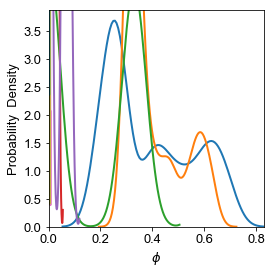

In [143]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 13}
plt.rc('font', **font)

#### Phi ######
plt.figure(figsize = (4,4)); 
plot_phi_estimates(trace[-600:]); 
plt.xlabel('$\phi$'); 
plt.ylabel('Probability  Density'); 
plt.tight_layout()
plt.savefig('tremblay_model4.pdf')

# Plotting Grain Radii Estimates

In [144]:
def plot_a_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['a'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(0,trace['a'].max() + 0.0005)

(0, 500)

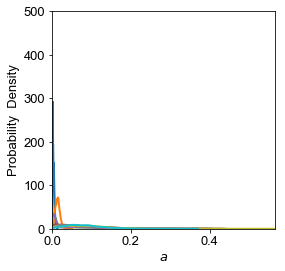

In [145]:
#### a ######
plt.figure(figsize = (4,4)); 
plot_a_estimates(trace); 
plt.xlabel('$a$'); 
plt.ylabel('Probability  Density'); 
plt.ylim(0, 500)

# Plot Activation Energy Estimates 

In [146]:
def plot_Ea_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['Ea'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(trace['Ea'].min() - 6,trace['Ea'].max() + 5)
        plt.ylim(0,0.7)

In [147]:
#### Ea ######
plt.figure(figsize = (4,4)); 
plot_Ea_estimates(trace); 
plt.xlabel('$E_a$'); 
plt.ylabel('Probability  Density'); 

IndexError: too many indices for array

<Figure size 288x288 with 0 Axes>

# Plot Frequency Factor Estimates 

In [261]:
def plot_D0_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['D0'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(trace['D0'].min() - 6,trace['D0'].max() + 5)
        plt.ylim(0,0.7)

In [262]:
#### D0 ######
plt.figure(figsize = (4,4)); 
plot_D0_estimates(trace); 
plt.xlabel('$D_0$'); 
plt.ylabel('Probability  Density'); 

IndexError: too many indices for array

<Figure size 320x320 with 0 Axes>